In [1]:
import shutil
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cosine_annearing_with_warmup as cosine
from tqdm.auto import tqdm, trange
import random
import pandas as pd
from PIL import Image
from pathlib import Path
from collections import OrderedDict

from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader

from adamp import SGDP
from adamp import AdamP
import torch.optim as optim
# from torchsummary import summary
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from torchensemble import VotingClassifier
#Kfold를 사용하기 위해서 import 하는 패키지들 

In [2]:
train_on_gpu= torch.cuda.is_available()
if not train_on_gpu:
    device ="cpu"
    print("CUDA is not available! Training on {}".format(device))
else:
    device = "cuda"
    print("CUDA is available! Training on {}".format(device))

CUDA is available! Training on cuda


In [3]:
data_dir = 'archive'
dataset = datasets.ImageFolder(data_dir)
dataset.__getitem__(0)[0]
len(dataset)
#20000: Negative  12457: Positive

32457

In [4]:
dumy_transform = transforms.Compose([transforms.ToTensor()])
dumydata = datasets.ImageFolder(data_dir, transform = dumy_transform)
dumyloader = DataLoader(dumydata , batch_size = 2048,shuffle = True)

In [5]:
images, label = next(iter(dumyloader))
arr = np.array([])
for i in range(3):
    arr = np.append(arr, [torch.mean(images[:,i]) , torch.std(images[:,i])])
MEAN = (arr[0],arr[2],arr[4])
STD = (arr[1], arr[3],arr[5])
MEAN ,STD

((0.7050679326057434, 0.6842020153999329, 0.6502107977867126),
 (0.12423917651176453, 0.12129557132720947, 0.1213388442993164))

In [6]:
classes = []
for i in range(len(glob.glob('archive/*'))):
    classes.append(glob.glob('archive/*')[i].split("archive\\")[1])
classes

['Negative', 'Positive']

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 227
batch_size =64
num_classes = 2
num_workers = 0

In [8]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.ColorJitter(1),
#                                       transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(50 , fill=200),
                                      transforms.RandomPerspective(p=0.5,fill=200),
#                                       transforms.RandomRotation(30),
#                                       transforms.RandomVerticalFlip(),
#                                       transforms.RandomAffine(15),
#                                       transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(MEAN,STD)])
#지용이형 말로는 horizontal, vertical은 학습에 별로 도움이 안되는 것 같다고 하셨다. 사진을 뒤집는 것 만으로는 학습이 유의미 하지 않다는 의미? 
valid_transform = transforms.Compose([transforms.Resize(224),

                                     transforms.ToTensor(),
                                      transforms.Normalize(MEAN,STD)])
train_data = datasets.ImageFolder(data_dir , transform = train_transform)
valid_data = datasets.ImageFolder(data_dir  , transform  =valid_transform)

train_size = 0.7
valid_size = 0.3
test_size = 0.1
num_train = len(train_data)
num_train = int(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split=  int(np.floor(valid_size*num_train))
test_split =  int(np.floor(test_size*num_train))
#################
train_idx, valid_idx ,test_idx= indices[valid_split:],indices[:test_split],indices[test_split:valid_split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler  = SubsetRandomSampler(test_idx)

#####################
train_loader = DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers) 
test_loader = DataLoader(valid_data , batch_size = batch_size,
    sampler = test_sampler, num_workers = num_workers)

train_loader.batch_size

64

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ..\aten\src\ATen\LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


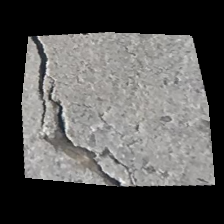

In [9]:
# valid_data = datasets.ImageFolder('archive/' , transform  =valid_transform)
valid_test_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(20),
                                      transforms.RandomPerspective(p=0.5)])

valid_test_data = datasets.ImageFolder(data_dir  , transform  =valid_test_transform)
valid_test_data.__getitem__(32000)[0]


In [10]:
class InceptionModule(nn.Module): #inception모듈 
    def __init__(self,in_channels=128):
        super(InceptionModule, self).__init__()
        
        self.y1 = nn.Sequential(*self.conv2d_1k(in_channels))
        self.y2 = nn.Sequential(*(self.conv2d_1k(in_channels)+self.conv2d_3k(in_channels)))
        self.y3 = nn.Sequential(*([nn.AvgPool2d(1)]+self.conv2d_3k(in_channels)))
        self.y4 = nn.Sequential(*(self.conv2d_1k(in_channels)+ self.conv2d_3k(in_channels)+ self.conv2d_1k(in_channels)))
    
    def conv2d_3k(self,in_channel):
        return [nn.Conv2d(in_channel, in_channel, 3,padding =1 ,bias = False ),
                nn.BatchNorm2d(in_channel),
               nn.SiLU()]
    
    def conv2d_1k(self,in_channel):
        return [nn.Conv2d(in_channel,in_channel,1,bias = False),
                nn.BatchNorm2d(in_channel),
               nn.SiLU()]
    
    def forward(self,x):
        y1 = self.y1(x)
        y2 = self.y2(x)
        y3 = self.y3(x)
        y4 = self.y4(x)
        out = torch.cat([y1,y2,y3,y4],dim=1)
        return out
    
  #inception ver2
class Crack(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        conv1= self.conv_block1(3,4) # 224=> 112
        Inception1 = [InceptionModule(4),nn.BatchNorm2d(4*4),nn.SiLU()]+[nn.MaxPool2d(2,2)]#112=> 56
        Inception2 = [InceptionModule(16),nn.BatchNorm2d(16*4),nn.SiLU()]+[nn.MaxPool2d(2,2)] #56=>28
        Inception3 = [InceptionModule(64),nn.BatchNorm2d(64*4),nn.SiLU()]+[nn.MaxPool2d(2,2)]#28=>14
        Inception4 = [InceptionModule(256),nn.BatchNorm2d(1024),nn.SiLU()]+self.Bottleneck2(1024)+ [nn.MaxPool2d(2,2)]#14=>7
        fc1=  self.lin_block(256*7*7,256)+[nn.Dropout(0.5),nn.Linear(256,15)]
        
        self.conv1 = nn.Sequential(*conv1)
        self.Inception = nn.Sequential(*Inception1)
        self.Inception2 = nn.Sequential(*Inception2)     
        self.Inception3 = nn.Sequential(*Inception3)
        self.Inception4 = nn.Sequential(*Inception4)      
        self.fc = nn.Sequential(*fc1)     


    def conv_block1(self,in_channel, out_channel):
        conv1 = [nn.Conv2d(in_channel,out_channel,3,padding =1,bias= False),
                             nn.BatchNorm2d(out_channel),
                             nn.SiLU(),
                            nn.MaxPool2d(2,2)]
        #list로 반환 
        return conv1
    def conv_block2(self,in_channel, out_channel):
        conv2=[nn.Conv2d(in_channel,out_channel,3,padding = 1,bias= False),
                            nn.BatchNorm2d(out_channel),
                            nn.SiLU(),
                            nn.Conv2d(out_channel,out_channel,3,padding = 1),
                            nn.SiLU(),
                            nn.Conv2d(out_channel, out_channel,3,padding =1),
                            nn.SiLU(),
                              nn.MaxPool2d(2,2)]
        return conv2
    def Bottleneck(self, in_channel):
        Bottleneck = [nn.Conv2d(in_channel ,in_channel//4,1),
                                   nn.BatchNorm2d(in_channel//4),
                                  nn.SiLU(),
                                  nn.Conv2d(in_channel//4,in_channel//4,3,padding =1),
                                  nn.BatchNorm2d(in_channel//4),
                                   nn.SiLU(),
                                  nn.Conv2d(in_channel//4, in_channel, 1),
                                  nn.BatchNorm2d(in_channel),
                                  nn.SiLU()] # bottleneck
        return Bottleneck
    def Bottleneck2(self, in_channel):
        Bottleneck2 = [nn.Conv2d(in_channel, in_channel//8,1), # 512 -> 64
                nn.BatchNorm2d(in_channel//8),
                nn.SiLU(),
                nn.Conv2d(in_channel//8, in_channel//8,3,padding =1),#64-> 64
                nn.BatchNorm2d(in_channel//8),
                nn.SiLU(),
                nn.Conv2d(in_channel//8, in_channel//4,1),#64 -> 128
                nn.BatchNorm2d(in_channel//4),
                nn.SiLU()]
        return Bottleneck2
    
    def lin_block(self,in_channel, out_channel):
        lin = [nn.Linear(in_channel, out_channel,bias =False ),
              nn.BatchNorm1d(out_channel),
               nn.SiLU(),
              nn.Dropout(0.5)]
        return lin
    def forward(self,x):
        x = self.conv1(x)
        x = self.Inception(x)
        x = self.Inception2(x)
        x = self.Inception3(x)
        x = self.Inception4(x)
        x = x.view(x.shape[0],-1)
        x= self.fc(x)
        return x
model = Crack()
model.to(device)
model

Crack(
  (conv1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Inception): Sequential(
    (0): InceptionModule(
      (y1): Sequential(
        (0): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (y2): Sequential(
        (0): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SiLU()
      )
     

In [15]:
summary(model, (1,3,224,244))

Layer (type:depth-idx)                   Output Shape              Param #
Crack                                    --                        --
├─Sequential: 1-1                        [1, 4, 112, 122]          --
│    └─Conv2d: 2-1                       [1, 4, 224, 244]          108
│    └─BatchNorm2d: 2-2                  [1, 4, 224, 244]          8
│    └─SiLU: 2-3                         [1, 4, 224, 244]          --
│    └─MaxPool2d: 2-4                    [1, 4, 112, 122]          --
├─Sequential: 1-2                        [1, 16, 56, 61]           --
│    └─InceptionModule: 2-5              [1, 16, 112, 122]         --
│    │    └─Sequential: 3-1              [1, 4, 112, 122]          24
│    │    └─Sequential: 3-2              [1, 4, 112, 122]          176
│    │    └─Sequential: 3-3              [1, 4, 112, 122]          152
│    │    └─Sequential: 3-4              [1, 4, 112, 122]          200
│    └─BatchNorm2d: 2-6                  [1, 16, 112, 122]         32
│    └─SiLU:

In [12]:
model = Crack()
model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(),lr= 1e-3)
# scheduler = cosine.CosineAnnealingWarmupRestarts(optimizer,
#                                                 first_cycle_steps=100,
#                                                 cycle_mult=1,
#                                                 max_lr=1e-1,
#                                                 min_lr=1e-3,
#                                                 warmup_steps=50,
#                                                 gamma=0.5)

optimizer = optim.SGD(model.parameters(),lr= 1e-1,momentum=0.9,weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'min',patience=10,factor = 0.1)#factor: alpha, patience = epochs


In [16]:


# def train(net,n_epochs = 30,train_loader, optimizer,scheduler, crieterion,device ="cuda"):
set_optimizer = 1
n_epochs = 3
early_stop = 0
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)
lr_list = torch.zeros(n_epochs)
train_loss_min = np.inf
valid_loss_min = np.inf
#gradient를 뽑아내고 싶은데 어떻게 해야할까 
for e in trange(0, n_epochs):
    torch.cuda.empty_cache()
    ###################
    # train the model #
    ###################
    early_stop+=1
    model.train()
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device) # cuda로 보냄 
        optimizer.zero_grad() #gradient계산 
        logits = model(data)#predict
        loss = criterion(logits, labels)#loss구함
        loss.backward()#미분한다. 
        optimizer.step()#업데이트 
        train_loss[e] += loss.item()#loss를 train에 삽입 

        ps = F.softmax(logits, dim=1)#확률을 구하고, 
        top_p, top_class = ps.topk(1, dim=1)#좋은 index를 뽑아낸다. 
        equals = top_class == labels.reshape(top_class.shape)#같은지를 비교하고, 
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()#정확도를 계산합니다. 

    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
    ######################    
    # validate the model #
    ######################
    with torch.no_grad():#validation은 미분이 필요 없습니다.
        model.eval()#dropout을 끈다음 validation에 대해서 학습을 진행 
        for data, labels in valid_loader:
            data, labels = data.to(device), labels.to(device) #to cuda
            logits = model(data) #predict calculate
            loss = criterion(logits, labels) # loss 구하고, 
            valid_loss[e] += loss.item()#valid_loss calculate
            ps = F.softmax(logits, dim=1)# ps calculate 
            top_p, top_class = ps.topk(1, dim=1) # index뽑고 
            equals = top_class == labels.reshape(top_class.shape) #정확도 계산 
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu() # cpu에서 연산합니다 .
            
    if set_optimizer == 0: #optimizer를 번갈아서 사용하기 위해서 만든 dumy 변수입니다. 
        scheduler.step()
    elif set_optimizer == 1:
        scheduler.step(valid_loss[e])
    valid_loss[e] /= len(valid_loader)#loss
    valid_acc[e] /= len(valid_loader)#정확도 
    lr_list[e]  =   scheduler.optimizer.param_groups[0]['lr'] #lr를 보려고 만듬 
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e,train_loss[e], valid_loss[e]))

    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
     
    print("current lr:  {}".format(scheduler.optimizer.param_groups[0]['lr']))
    if valid_loss[e] <= valid_loss_min:
        early_stop = 0
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,valid_loss[e]))
        torch.save(model.state_dict(), 'pt/model_store.pt')
        valid_loss_min = valid_loss[e]
print("Finished_Training")
idx = torch.argmin(valid_loss)
i = torch.argmin(train_loss)
print('--------------\nepoch:{}\nbest train_loss: train:{:.3f} valid:{:.3f}, '.format(i+1,train_loss[i],valid_loss[i]))
print('best train_acc: train:{:.3f} valid:{:.3f}, '.format(train_acc[i],valid_acc[i]))
print('--------------\nepoch:{}\nbest valid_loss: train:{:.3f} valid:{:.3f}, '.format(idx+1,train_loss[idx],valid_loss[idx]))
print('best valid_acc: train:{:.3f} valid:{:.3f}, '.format(train_acc[idx],valid_acc[idx]))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 0.302363 	Validation Loss: 0.072055
Epoch: 0 	Training accuracy: 0.887456 	Validation accuracy: 0.984423
current lr:  0.1
Validation loss decreased (inf --> 0.072055).  Saving model ...
Epoch: 1 	Training Loss: 0.225878 	Validation Loss: 0.043712
Epoch: 1 	Training accuracy: 0.923988 	Validation accuracy: 0.989890
current lr:  0.1
Validation loss decreased (0.072055 --> 0.043712).  Saving model ...
Epoch: 2 	Training Loss: 0.204712 	Validation Loss: 0.040222
Epoch: 2 	Training accuracy: 0.933583 	Validation accuracy: 0.993873
current lr:  0.1
Validation loss decreased (0.043712 --> 0.040222).  Saving model ...
Finished_Training
--------------
epoch:3
best train_loss: train:0.205 valid:0.040, 
best train_acc: train:0.934 valid:0.994, 
--------------
epoch:3
best valid_loss: train:0.205 valid:0.040, 
best valid_acc: train:0.934 valid:0.994, 


In [ ]:
print('no validation')
f,ax = plt.subplots(1,3)
ax[0].plot(train_loss, label='Training loss')
ax[0].plot(valid_loss, label='Validation loss')
ax[0].legend(frameon=False)

ax[0].set_title('loss')

ax[1].plot(train_acc, label='Training acc')
ax[1].plot(valid_acc, label='Validation acc')
ax[1].legend(frameon=False)
ax[1].set_title('accuracy')
# index+=1
ax[2].plot(lr_list, label='lr ')
ax[2].legend(frameon=False)
ax[2].set_title('learning rate')
#loss와 accuracy, learning rate를 보여줍니다! 
f.tight_layout()#layout_을 자동으로 맞춰준다.
# plt.savefig(f'plot_model_data_augmentation2',facecolor = "w")


In [ ]:
model.load_state_dict(torch.load('pt/model_store.pt'))

In [ ]:
# valid_data = datasets.ImageFolder('archive/' , transform  =valid_transform)
valid_test_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.ColorJitter(1),
#                                       transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(50 , fill=200),
                                      transforms.RandomPerspective(p=0.5,fill=200),])

valid_test_data = datasets.ImageFolder(data_dir  , transform  =valid_test_transform)
valid_test_data.__getitem__(32000)[0]


In [ ]:
# valid_data = datasets.ImageFolder('archive/' , transform  =valid_transform)
Test_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.ColorJitter(1),
#                                       transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(50 , fill=200),
                                      transforms.RandomPerspective(p=0.5,fill=200),
                                     transforms.ToTensor(),
                                      transforms.Normalize(MEAN,STD)])
test_data = datasets.ImageFolder(data_dir  , transform  =Test_transform)
test_loader = DataLoader(test_data , batch_size = batch_size,
    sampler = test_sampler, num_workers = num_workers)


In [ ]:
model.load_state_dict(torch.load('pt/model_store.pt'))
# track test loss
test_loss = 0.0
test_acc = 0.0

class_correct = torch.zeros(2)
class_total = torch.zeros(2)

model.eval()
# iterate over test data
for data, labels in test_loader:
    # move tensors to GPU if CUDA is available
    data, labels = data.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    logits = model(data)
    # calculate the batch loss
    loss = criterion(logits, labels)
    # update test loss 
    test_loss += loss.item() # item()이라는 명령어를 쓰면 cpu로 옮겨줍니다.
    
    ps = F.softmax(logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.reshape(top_class.shape) # 여기까지는 gpu에서 연산이 되다가 
    test_acc += torch.mean(equals.type(torch.float)).detach().cpu() # detack: gpu에 있던것을 끊고 가지고 온다.
    #test라는 cpu에 넣으면 오류남
    for i in range(len(data)):
        label = labels[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader)
test_acc = test_acc/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: {:.6f}\n'.format(test_acc))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            torch.sum(class_correct[i]), torch.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

In [ ]:
# model.load_state_dict(torch.load('pt/Cnn_model.pt'))
# # track test loss
# test_loss = 0.0
# test_acc = 0.0

# class_correct = torch.zeros(2)
# class_total = torch.zeros(2)

# model.eval()
# # iterate over test data
# for data, labels in test_loader:
#     # move tensors to GPU if CUDA is available
#     data, labels = data.to(device), labels.to(device)
#     # forward pass: compute predicted outputs by passing inputs to the model
#     logits = model(data)
#     # calculate the batch loss
#     loss = criterion(logits, labels)
#     # update test loss 
#     test_loss += loss.item() # item()이라는 명령어를 쓰면 cpu로 옮겨줍니다.
    
#     ps = F.softmax(logits, dim=1)
#     top_p, top_class = ps.topk(1, dim=1)
#     equals = top_class == labels.reshape(top_class.shape) # 여기까지는 gpu에서 연산이 되다가 
#     test_acc += torch.mean(equals.type(torch.float)).detach().cpu() # detack: gpu에 있던것을 끊고 가지고 온다.
#     #test라는 cpu에 넣으면 오류남
#     for i in range(len(data)):
#         label = labels[i]
#         class_correct[label] += equals[i].item()
#         class_total[label] += 1
    

# # average test loss
# test_loss = test_loss/len(test_loader)
# test_acc = test_acc/len(test_loader)
# print('Test Loss: {:.6f}\n'.format(test_loss))
# print('Test Accuracy: {:.6f}\n'.format(test_acc))

# for i in range(2):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             classes[i], 100 * class_correct[i] / class_total[i],
#             torch.sum(class_correct[i]), torch.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

In [14]:
# class Crack(nn.Module):
#     def __init__(self):
#         super(Crack,self).__init__()
#         self.class_num = 2
#         self.padding = 1
#         self.stride = 1
#         self.kernel_size =3
        
#         self.conv_dim = [3,16,32,32,64,64] #112 56 28 14 7 
#         self.fc_dim = [64*7*7,1024,256]
#         self.dropout =[0.3,0.3,0.3]
#         conv = []
#         for i , (in_channel,out_channel) in enumerate(zip(self.conv_dim[:-1],self.conv_dim[1:])):
#             if i<0:
#                 conv += self.conv_block(in_channel,out_channel)
#             else:
#                 conv += self.conv_block(in_channel,out_channel)+[nn.MaxPool2d(2,2)]
                
#         fc = []
#         for i, (in_channel,out_channel) in enumerate(zip(self.fc_dim[:-1],self.fc_dim[1:])):
#             if i<0.:
#                 fc+= self.lin_block(in_channel,out_channel)+[nn.Dropout(self.dropout[i])]
#             else:
#                 fc+=self.lin_block(in_channel,out_channel)
#         fc+=[nn.Linear(self.fc_dim[-1],self.class_num)]
#         self.conv = nn.Sequential(*conv)
#         self.fc = nn.Sequential(*fc)
    
#     def conv_block(self,in_channel,out_channel):
#         return [nn.Conv2d(in_channel, out_channel,kernel_size= self.kernel_size,
#                           padding = self.padding, stride = self.stride, bias =False),
#                nn.BatchNorm2d(out_channel),
#                nn.SiLU(True)]
    
    
#     def lin_block(self,in_channel, out_channel):
#         return [nn.Linear(in_channel, out_channel,bias= False),
#                nn.BatchNorm1d(out_channel),
#                nn.SiLU(True)]
    
    
#     def forward(self,x):
#         x = self.conv(x)
#         x = x.view(x.shape[0],-1)
#         x = self.fc(x)
#         return x
# model = Crack()
# model.to(device)
# model

In [13]:
# summary(model, (1,3,224,224))